In [176]:
%store -r car_data_updated
%store -r categorical_columns
%store -r numerical_columns
%store -r car_data
%store -r car_data_updated_1

# Preprocessing

The objective of this project is to build models to predict the price of car as a function of features that define a car and and to study how the variation of the different features affect the price of the car

The purpose of this notebook is to use an algorithm to define a initial vbaseline to compare to other more powerful algorithms.

Table of Contents

[d.1 Train/test split](#d.1)

[d.2 Standard scaling](#d.2)

[d.3 Linear regression with cross-validation](#d.3)

[d.4 Lasso and Ridge Regression](#d.4)

[d.5 Metrics Evaluation on Test Set](#d.5)

In [177]:
# Import necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from scipy import stats

<a id="d.1"></a>
## d.1 Train/test split

In [178]:
from sklearn.model_selection import train_test_split

# Define the features and the target
#X = car_data_encoded.drop('price', axis=1)
#y = car_data_encoded['price']

# Define the features and the target
X = car_data_updated_1.drop(['price', 'car_ID',  'symboling'], axis=1)
y = car_data_updated_1['price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [179]:
X_train.shape, y_train.shape,X_test.shape,y_test.shape

((153, 18), (153,), (52, 18), (52,))

In [180]:
# Displaying data types of all columns
column_data_types = X_train.dtypes

# Analyze each column to categorize them
categorical_columns = []
numerical_columns = []

for column, dtype in column_data_types.items():
    if dtype == 'object':
        categorical_columns.append(column)
    else:
        numerical_columns.append(column)

# Print the results
print("Categorical Columns:")
print(categorical_columns)
print("\nNumerical Columns:")
print(numerical_columns)

Categorical Columns:
['fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem', 'CompanyName']

Numerical Columns:
['carheight', 'boreratio', 'stroke', 'compressionratio', 'peakrpm', 'carsize', 'fuelefficiency', 'carpower']


In [181]:
#Apply onehotencoder
from sklearn.preprocessing import OneHotEncoder

# Apply One-Hot Encode to categorical variables
ohe = OneHotEncoder(handle_unknown='ignore')
X_train_encoded_categorical = ohe.fit_transform(X_train[categorical_columns])  # example categorical columns
X_test_encoded_categorical = ohe.transform(X_test[categorical_columns])

# Convert encoded data to dataframe
encoded_columns = ohe.get_feature_names_out(categorical_columns)
X_train_encoded_categorical_df = pd.DataFrame(X_train_encoded_categorical.toarray(), columns=encoded_columns, index=X_train.index)
X_test_encoded_categorical_df = pd.DataFrame(X_test_encoded_categorical.toarray(), columns=encoded_columns, index=X_test.index)

#reset index
X_train_encoded_categorical_df = X_train_encoded_categorical_df.reset_index(drop=True)
X_train_numerical_df = X_train[numerical_columns].reset_index(drop=True)

#reset index
X_test_encoded_categorical_df = X_test_encoded_categorical_df.reset_index(drop=True)
X_test_numerical_df = X_test[numerical_columns].reset_index(drop=True)

# Combine with continuous data
X_train_encoded = pd.concat([X_train_encoded_categorical_df, X_train_numerical_df], axis=1)
X_test_encoded = pd.concat([X_test_encoded_categorical_df, X_test_numerical_df], axis=1)

# Capture new column names after one-hot encoding
#new_columns = ohe.get_feature_names_out(input_features=categorical_columns)  # This gets the new column names

# If there are continuous features as well, concatenate their names with the new columns from one-hot encoding
#continuous_columns = [col for col in X_train.columns if col not in categorical_columns]
#column_names = list(continuous_columns) + list(new_columns)
column_names = X_test_encoded.columns.tolist()


In [182]:
X_train_encoded.columns, X_test_encoded.columns, column_names

(Index(['fueltype_diesel', 'fueltype_gas', 'aspiration_std', 'aspiration_turbo',
        'doornumber_four', 'doornumber_two', 'carbody_convertible',
        'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
        'carbody_wagon', 'drivewheel_4wd', 'drivewheel_fwd', 'drivewheel_rwd',
        'enginelocation_front', 'enginelocation_rear', 'enginetype_dohc',
        'enginetype_dohcv', 'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf',
        'enginetype_ohcv', 'enginetype_rotor', 'cylindernumber_eight',
        'cylindernumber_five', 'cylindernumber_four', 'cylindernumber_six',
        'cylindernumber_twelve', 'cylindernumber_two', 'fuelsystem_1bbl',
        'fuelsystem_2bbl', 'fuelsystem_4bbl', 'fuelsystem_idi',
        'fuelsystem_mpfi', 'fuelsystem_spdi', 'fuelsystem_spfi',
        'CompanyName_alfa-romero', 'CompanyName_audi', 'CompanyName_bmw',
        'CompanyName_buick', 'CompanyName_chevrolet', 'CompanyName_dodge',
        'CompanyName_honda', 'CompanyName_isuzu', 'Co

In [183]:
X_train_encoded.head()

,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,doornumber_four,doornumber_two,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,...,CompanyName_volkswagen,CompanyName_volvo,carheight,boreratio,stroke,compressionratio,peakrpm,carsize,fuelefficiency,carpower
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,54.5,2.99,3.47,21.9,4800,107.866667,0.047100,79.0
1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,54.9,3.31,3.54,8.7,4200,114.833333,0.027085,107.0
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,53.5,3.15,3.29,9.4,5200,109.500000,0.033597,83.0
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,53.1,3.19,3.40,8.5,5500,114.466667,0.017551,123.0
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,52.0,3.62,3.50,9.3,4800,113.400000,0.021260,131.0


<a id="d.2"></a>
## d.2 Standard scaling

In [184]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


# Initialize the scaler
scaler = StandardScaler(with_mean=False) # Set with_mean to False


# Fit the scaler on the training set
scaler.fit(X_train_encoded)

# Transform both the training and test sets
X_train_scaled = scaler.transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)



<a id="d.3"></a>
## d.3 Linear regression with cross-validation

In [193]:
from sklearn.model_selection import KFold

# Optionally: Convert y_train to a numpy array or reset its index if it's a DataFrame
y_train = np.array(y_train)  # Convert to numpy array if not already


# Initialize the Linear Regression model
linear_model = LinearRegression()

# Define the K-Fold Cross-Validator
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize variables to store scores
total_rmse_test = 0
total_rmse_train = 0


# Perform K-Fold Cross-Validation on the training data
for train_index, test_index in kf.split(X_train_scaled):
    # Split data into training and testing sets for this fold
    X_train_kf, X_test_kf = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_kf, y_test_kf = y_train[train_index], y_train[test_index]
    
    # Fit the model to the training data
    linear_model.fit(X_train_kf, y_train_kf)
    
    # Make predictions on the test data
    predictions_test = linear_model.predict(X_test_kf)
    predictions_train = linear_model.predict(X_train_kf)
    
    # Calculate RMSE for this fold
    rmse_test = mean_squared_error(y_test_kf, predictions_test, squared=False)
    rmse_train = mean_squared_error(y_train_kf, predictions_train, squared=False)  # Training RMSE
    
    # Accumulate total RMSE
    total_rmse_test += rmse_test
    total_rmse_train += rmse_train

# Calculate and print the average RMSE across all folds
average_rmse_test = total_rmse_test / k
average_rmse_train = total_rmse_train / k
print(f"Average RMSE across {k} folds (Cross-Validation) - Test: {average_rmse_test}")
print(f"Average RMSE across {k} folds (Cross-Validation) - Train: {average_rmse_train}")

# Fit the model on the entire training set
linear_model.fit(X_train_scaled, y_train)

# Make predictions on the testing set
final_predictions = linear_model.predict(X_test_scaled)
preds_linear = final_predictions
# Calculate and print the final RMSE on the testing set
final_test_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print("Final Test RMSE:", final_test_rmse)

Average RMSE across 5 folds (Cross-Validation) - Test: 1.8667584136347696e+16
Average RMSE across 5 folds (Cross-Validation) - Train: 1237.739121615883
Final Test RMSE: 4695442573583544.0


The linear model had much lower error on the training data compared to the testing data, it might have been overfitting.

<a id="d.4"></a>
## d.4 Lasso and Ridge Regression

In [195]:
# Lasso Regrssion with Cross-Validation
from sklearn.linear_model import LassoCV

# List of alphas to try out
alphas = np.logspace(-4, 4, 20)

# Lasso Regression with Cross-Validation
lasso_cv = LassoCV(alphas=alphas, cv=5)  # 5-fold cross-validation
lasso_cv.fit(X_train_scaled, y_train)

# Optimal alpha and corresponding RMSE
optimal_lasso_alpha = lasso_cv.alpha_
lasso_cv_rmse = mean_squared_error(y_test, lasso_cv.predict(X_test_scaled), squared=False)
preds_lasso = lasso_cv.predict(X_test_scaled)
print("Optimal Lasso Alpha:", optimal_lasso_alpha)
print("Lasso Testing RMSE with Optimal Alpha:", lasso_cv_rmse)


Optimal Lasso Alpha: 78.47599703514607
Lasso Testing RMSE with Optimal Alpha: 2736.1669962969295


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1476724.820545733, tolerance: 728392.0926540652
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1290736.4376580417, tolerance: 728392.0926540652
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1270034.5083234906, tolerance: 728392.0926540652
  model = cd_fast.enet_coordi

In [201]:
# Ridge Regression with Cross-Validation
from sklearn.linear_model import RidgeCV

# Ridge Regression with Cross-Validation
ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=5)  # 5-fold cross-validation
ridge_cv.fit(X_train_scaled, y_train)

# Optimal alpha and corresponding RMSE
optimal_ridge_alpha = ridge_cv.alpha_
ridge_cv_rmse = mean_squared_error(y_test, ridge_cv.predict(X_test_scaled), squared=False)
preds_ridge = ridge_cv.predict(X_test_scaled)
print("Optimal Ridge Alpha:", optimal_ridge_alpha)
print("Ridge Testing RMSE with Optimal Alpha:", ridge_cv_rmse)


Optimal Ridge Alpha: 4.281332398719396
Ridge Testing RMSE with Optimal Alpha: 2752.2428703880946


With Lasso and Ridge, the gap between training and testing error is reduced compared to the simple linear regression. Therefore, regularization does help to mitigate overfitting.

<a id="d.5"></a>
## d.5 Metrics Evaluation on Test Set

In [188]:
#Adjusted R-squared

from sklearn.metrics import r2_score

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)

# Calculate adjusted R-squared
n = len(y_test)  # number of observations in the test set
p = X_test_scaled.shape[1]  # number of predictors

adjusted_r_squared = 1 - (((1 - r_squared) * (n - 1)) / (n - p - 1))
print("Adjusted_r_squared:", adjusted_r_squared)

Adjusted_r_squared: 1.6621892076853948


For Adjusted R-squared: The value provided seems erroneous and should be investigated further. Adjusted R-squared should logically be between 0 and 1. So a different model is necessary. 

In [189]:
# MAPE: Mean Absolute Percent Error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE:", mape, "%")


MAPE: 16.785330508726144 %


For MAPE: The MAPE suggests the model's predictions are, on average, about 13.27% off from the actual values.

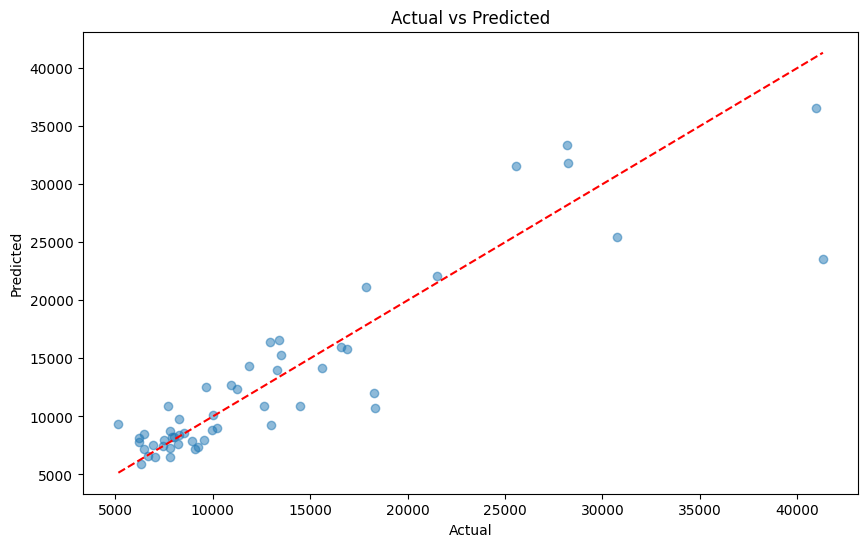

In [190]:
#Actual-vs-Predicted Scatter Plot

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # 45-degree line
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

There seems to be a positive linear relationship between the actual and predicted values, as indicated by the points generally following the dashed line, which represents a great fit.
There are some points far from the dashed line, indicating instances where the model's predictions are quite far from the actual values.
For higher values of the actual target variable, the model appears to be less accurate, with predictions deviating more from the line.

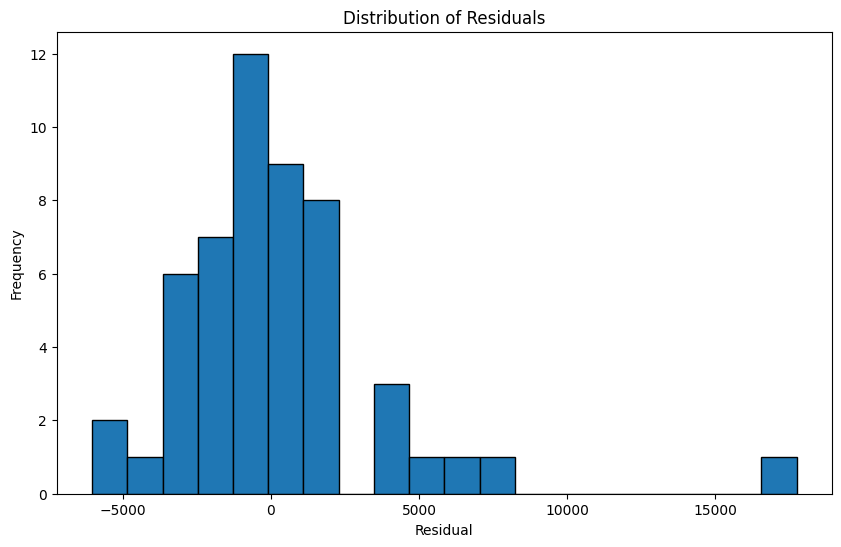

In [191]:
#Compute Residuals and Histogram
# Calculate residuals
residuals = y_test - y_pred

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

The peak of the histogram is around zero, which is good as it suggests that the model doesn't systematically overpredict or underpredict.
The distribution of the residuals doesn't seem perfectly normal; it is slightly skewed to the right, indicating a tail of instances where the model underpredicts the target variable.
The presence of a few large residuals (seen in the bars far from zero) could be potential outliers or instances where the model's assumptions might not hold.

Summary

Based on the provided plots, the regression model seems to be doing a reasonable job of capturing the relationship between the predictors and the target variable, with some potential issues with outliers and heteroscedasticity at higher value ranges. It would be beneficial to investigate additional modeling algorithms, such as random forests, LGBM etc.

In [202]:
%store X_train_scaled
%store X_test_scaled
%store y_train
%store y_test
%store column_names
%store preds_linear
%store preds_lasso
%store preds_ridge
from joblib import dump
models={'model1':lasso_cv, 'model2':ridge_cv}
dump(models, 'all_models_filename.joblib')

Stored 'X_train_scaled' (ndarray)
Stored 'X_test_scaled' (ndarray)
Stored 'y_train' (ndarray)
Stored 'y_test' (Series)
Stored 'column_names' (list)
Stored 'preds_linear' (ndarray)
Stored 'preds_lasso' (ndarray)
Stored 'preds_ridge' (ndarray)


['all_models_filename.joblib']